<a href="https://colab.research.google.com/github/kushalk20/Deep-Learning/blob/main/Deep%20Learning%20Project_2%20(Using%20CNN).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Importing the Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
import os
from matplotlib.image import imread
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Input,Convolution2D, MaxPooling2D, Dropout, Flatten, Dense # Import layers that will be used in modeling

import warnings
warnings.filterwarnings("ignore")

In [3]:
# Saving the Github Repository to Google Collab System
!git clone https://github.com/kushalk20/Datasets.git

Cloning into 'Datasets'...
remote: Enumerating objects: 17042, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 17042 (delta 1), reused 10 (delta 1), pack-reused 17032
Receiving objects: 100% (17042/17042), 241.63 MiB | 33.10 MiB/s, done.
Resolving deltas: 100% (1/1), done.
Updating files: 100% (17036/17036), done.


This is image data of Natural Scenes around the world.

This Data contains around 25k images of size 150x150 distributed under 6 categories.
{'buildings' -> 0,
'forest' -> 1,
'glacier' -> 2,
'mountain' -> 3,
'sea' -> 4,
'street' -> 5 }

The Train and Test is separated in each zip files. There are around 14k images in Train & 3k in Test

In [4]:
IMAGE_SIZE = (150, 150)
rescaled = ImageDataGenerator(1/255)
BATCH_SIZE = 32

In [5]:
train_dir='/content/Datasets/seg_train'
test_dir='/content/Datasets/seg_test'

In [6]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  image_size=IMAGE_SIZE,
  batch_size=BATCH_SIZE)

Found 14034 files belonging to 6 classes.


In [7]:
test_ds = tf.keras.utils.image_dataset_from_directory(
  test_dir,
  image_size=IMAGE_SIZE,
  batch_size=BATCH_SIZE)

Found 3000 files belonging to 6 classes.


In [90]:
y_labels = np.concatenate([y for x, y in test_ds], axis=0)

In [8]:
class_labels = train_ds.class_names
#class_labels = list(train_ds.class_indices.keys())
print(class_labels)

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


In [9]:
test_labels = test_ds.class_names
# test_labels = list(test_ds.class_indices.keys())
print(test_labels)

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


VISUALIZING THE DATA

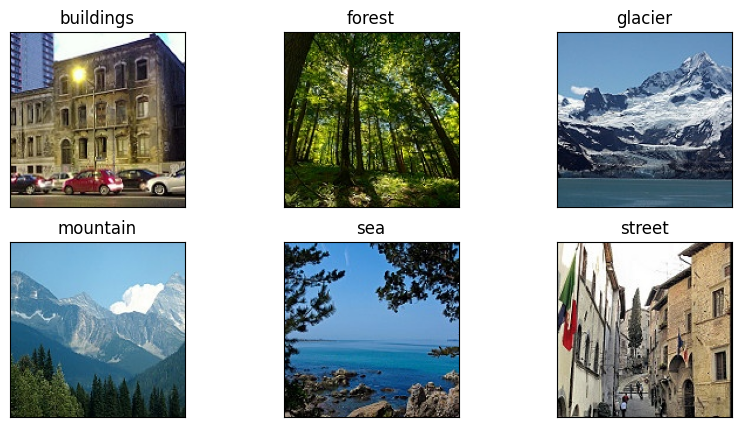

In [10]:
# Generating the Unique Images
fig = plt.figure(figsize=(10, 5))
for i in range(len(class_labels)):
    ax = fig.add_subplot(2, 3, 1 + i, xticks=[], yticks=[])
    class_dir = os.path.join(train_dir, class_labels[i])   # Specifies the location of each class
    img_filenames = os.listdir(class_dir)                 # Show all images which are specifed in above class
    img_path = os.path.join(class_dir, img_filenames[0])  # Selecting the first image of each class
    im = plt.imread(img_path)
    ax.set_title(class_labels[i])
    plt.imshow(im)
plt.show()

In [11]:
#numbers of images each classes in train set
n_ds = []
for i in class_labels:
    DIR = os.path.join(train_dir,i)
    images = len([name for name in os.listdir(DIR) if os.path.isfile(os.path.join(DIR, name))])
    n_ds.append(images)
print(n_ds)
classes_train = list(zip(class_labels, n_ds))

[2191, 2271, 2404, 2512, 2274, 2382]


In [12]:
print(classes_train)

[('buildings', 2191), ('forest', 2271), ('glacier', 2404), ('mountain', 2512), ('sea', 2274), ('street', 2382)]


In [13]:
#numbers of images each classes in test set
test_n_ds = []
for j in class_labels:
    DIR = os.path.join(test_dir,j)
    images = len([name for name in os.listdir(DIR) if os.path.isfile(os.path.join(DIR, name))])
    test_n_ds.append(images)
print(test_n_ds)
classes_test = list(zip(class_labels, test_n_ds))

[437, 474, 553, 525, 510, 501]


In [14]:
print(classes_test)

[('buildings', 437), ('forest', 474), ('glacier', 553), ('mountain', 525), ('sea', 510), ('street', 501)]


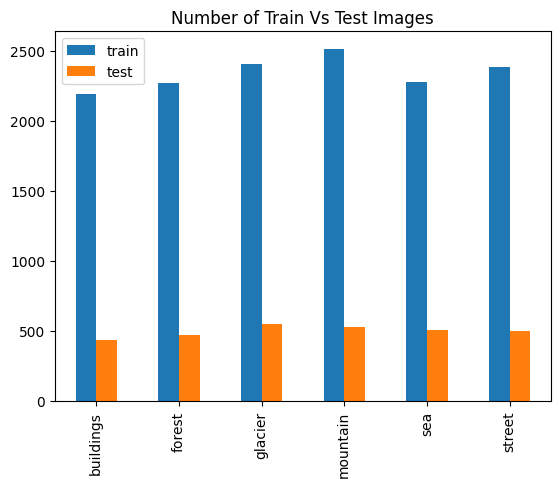

In [15]:
pd.DataFrame({'train': n_ds,
                    'test': test_n_ds},
             index=class_labels
            ).plot.bar()
plt.title('Number of Train Vs Test Images')
plt.show()

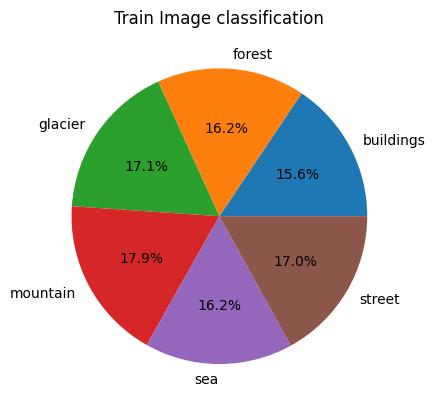

In [16]:
# Extract the labels and values into separate lists
labels = [x[0] for x in classes_train]
sizes = [x[1] for x in classes_train]

# Create the pie chart
plt.pie(sizes, labels=labels, autopct='%1.1f%%')

# Add a title
plt.title('Train Image classification')

# Show the plot
plt.show()

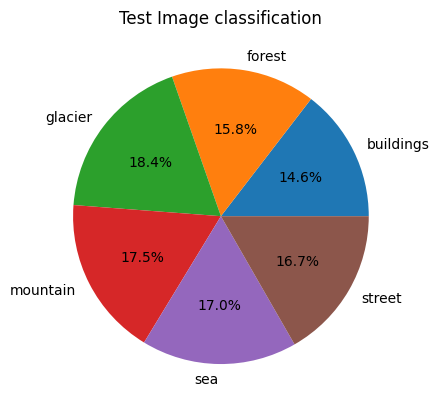

In [17]:
# Extract the labels and values into separate lists
labels = [x[0] for x in classes_test]
sizes = [x[1] for x in classes_test]

# Create the pie chart
plt.pie(sizes, labels=labels, autopct='%1.1f%%')

# Add a title
plt.title('Test Image classification')

# Show the plot
plt.show()

DEFINING THE CONSTANTS FOR THE MODEL

In [18]:
num_classes = len(class_labels)
num_classes

6

In [41]:
# Set some hyperparameters

batch_size = BATCH_SIZE   # A batch of 'batch_size' training examples is fed before

num_epochs = 10    # Over the entire training set, we iterate 50 times

kernel_size = 3   # we will use 3x3 kernels throughout

pool_size = 2     # we will use 2x2 pooling throughout

conv_depth_1 = 32 # we will initially have 32 filters per conv. layer...
                  # Remember each filter extracts some structure from image data

conv_depth_2 = 64 # ...switching to 64 filters after the first pooling layer

**BUILDING THE MODEL**

Steps are:       
1) Build the model.       
2) Compile the model       
3) Train / fit the data to the model.         
4) Evaluate the model on the testing set            
5) Conv2D: (32 filters of size 3 by 3) The features will be "extracted" from the image.             
6) MaxPooling2D: The images get half sized.                
7) Flatten: Transforms the format of the images from a 2d-array to a 1d-array of 150 150 3 pixel values.                
Relu : given a value x, returns max(x, 0).                
Softmax: 6 neurons, probability that the image belongs to one of the classes.




In [42]:
# Empty Model
model = tf.keras.Sequential()

In [43]:
model.add(Input(shape = (150,150,3)))

In [44]:
# Convolution Layer
# Weight contribution of this layer would be:
#       perFilterWts = kernel_size * kernel_size * depth + 1 (bias) = 28
#       Total wts = TotalFilters * perFilterWts = 32 * 28 = 896
model.add(
          Convolution2D(conv_depth_1,              # 32 filters
                        kernel_size,               # 3 X 3
                        activation='relu'
                       )
           )
# Pooling Layer
model.add(MaxPooling2D(
	                   pool_size=(pool_size, pool_size))         # 2 X 2
                      )

In [45]:
# Convolution Layer
model.add(
          Convolution2D(conv_depth_1,              # 32 filters
                        kernel_size,               # 3 X 3
                        activation='relu'
                       )
           )

# Pooling Layer
model.add(MaxPooling2D(
	                   pool_size=(pool_size, pool_size))         # 2 X 2
                      )

In [46]:
# Convolution Layer
model.add(
          Convolution2D(conv_depth_2,              # 64 filters
                        kernel_size,               # 3 X 3
                        activation='relu'
                       )
           )


# Pooling Layer
model.add(MaxPooling2D(
	                   pool_size=(pool_size, pool_size))         # 2 X 2
                      )

In [47]:
# Convolution Layer
model.add(
          Convolution2D(conv_depth_2,              # 64 filters
                        kernel_size,               # 3 X 3
                        activation='relu'
                       )
           )

In [48]:
model.add(tf.keras.layers.Flatten())

In [49]:
model.add(tf.keras.layers.Dense(1024, activation='relu'))
model.add(tf.keras.layers.Dense(512, activation='relu'))
model.add(tf.keras.layers.Dense(128, activation='relu'))

In [50]:
model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))

In [51]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 74, 74, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 72, 72, 32)        9248      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 34, 34, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 17, 17, 64)      

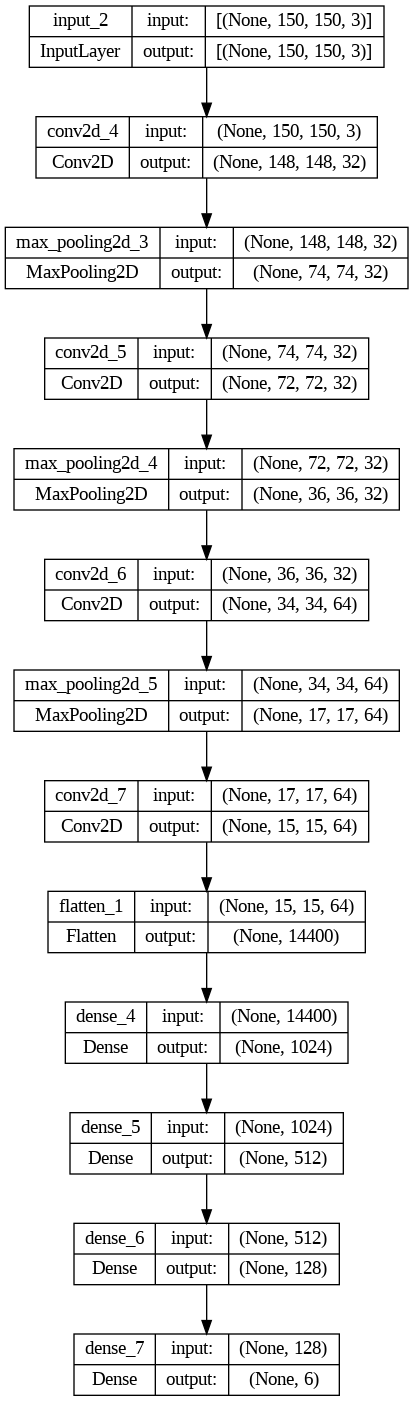

In [52]:
plot_model(model, show_shapes=True)

In [53]:
# Installing Visual Keras

!pip install visualkeras

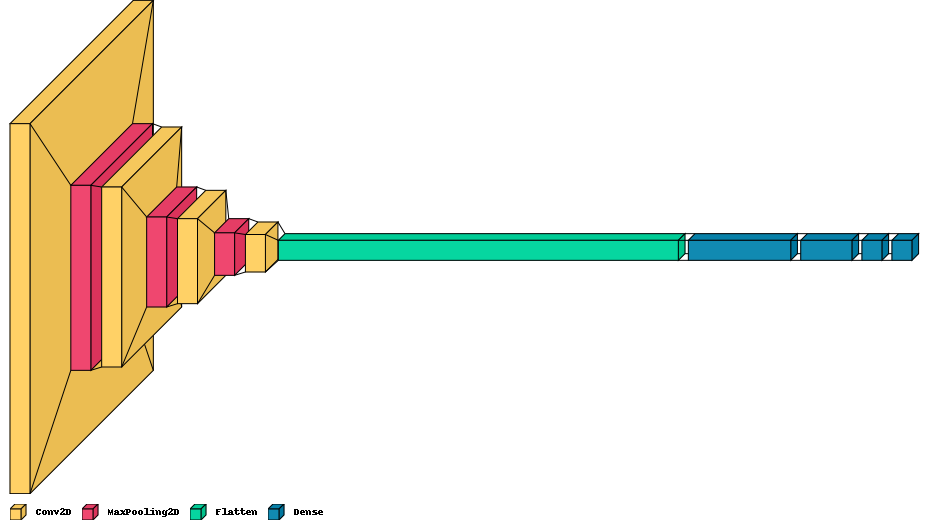

In [125]:
import visualkeras

# Visualize the model
visualkeras.layered_view(model, scale_xy=2.5, legend=True)

In [55]:
# Compile model
model.compile(
                 loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                 metrics = ["accuracy"]
              )

In [56]:
history = model.fit(
    train_ds,
    epochs=num_epochs)

Epoch 1/10
439/439 [==============================] - 581s 1s/step - loss: 4.3793 - accuracy: 0.2651
Epoch 2/10
439/439 [==============================] - 553s 1s/step - loss: 1.2858 - accuracy: 0.5038
Epoch 3/10
439/439 [==============================] - 570s 1s/step - loss: 1.0474 - accuracy: 0.6030
Epoch 4/10
439/439 [==============================] - 563s 1s/step - loss: 0.8700 - accuracy: 0.6869
Epoch 5/10
439/439 [==============================] - 550s 1s/step - loss: 0.7379 - accuracy: 0.7448
Epoch 6/10
439/439 [==============================] - 549s 1s/step - loss: 0.5708 - accuracy: 0.8033
Epoch 7/10
439/439 [==============================] - 535s 1s/step - loss: 0.4559 - accuracy: 0.8464
Epoch 8/10
439/439 [==============================] - 543s 1s/step - loss: 0.3784 - accuracy: 0.8799
Epoch 9/10
439/439 [==============================] - 536s 1s/step - loss: 0.3187 - accuracy: 0.9089
Epoch 10/10
439/439 [==============================] - 536s 1s/step - loss: 0.2952 - accura

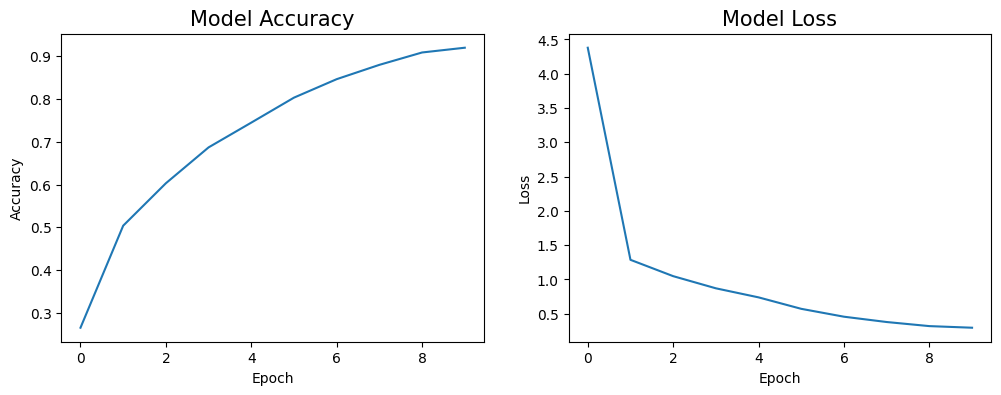

In [114]:
plt.figure(figsize=[12, 4])

# Summarize history for accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.title('Model Accuracy', size=15)
plt.ylabel('Accuracy', size=10)
plt.xlabel('Epoch', size=10)

# Summarize history for loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.title('Model Loss', size=15)
plt.ylabel('Loss', size=10)
plt.xlabel('Epoch', size=10)

plt.show()

In [60]:
# Making Predictons: It will give the probability of each class
predictions = model.predict(test_ds)

94/94 [==============================] - 33s 341ms/step


In [81]:
# np.argmax: Returns the indices of the maximum probabaility along an axis. .
y_pred = np.argmax(predictions, axis = 1)
y_pred

In [94]:
# Checking Accuracy on Test Data
np.sum(y_pred == y_labels)/3000

0.16333333333333333

In [141]:
# Building a function to Visualize the prediction
def predict_image(filename, model):
    img_ = image.load_img(filename, target_size=(150, 150))
    img_array = image.img_to_array(img_)
    img_processed = np.expand_dims(img_array, axis=0)
    img_processed /= 255.

    prediction = model.predict(img_processed)

    index = np.argmax(prediction)

    plt.title("Prediction - {}".format(str(test_labels[index]).title()), size=12, color='red')
    plt.imshow(img_array)

1/1 [==============================] - 0s 42ms/step


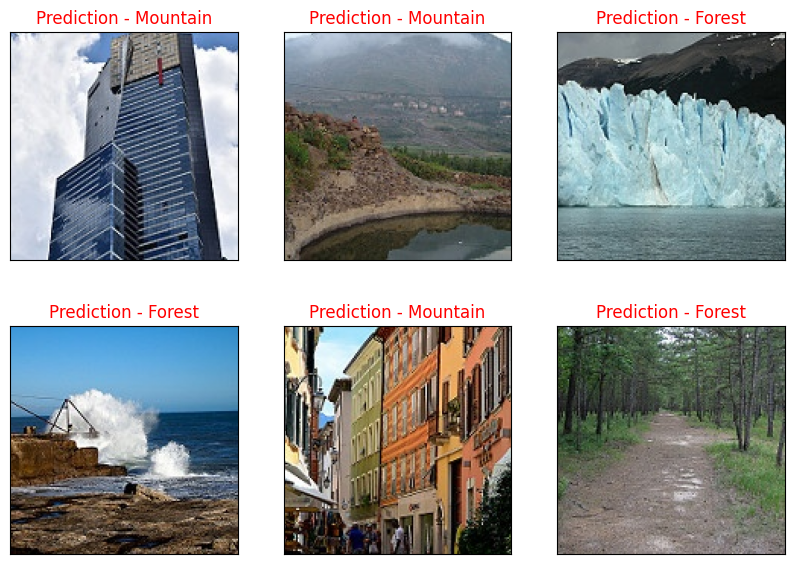

In [150]:
# Visualizing the one prediction of each class using the function & subplots
plt.figure(figsize=(10, 7))

plt.subplot(2,3,1, xticks=[], yticks=[])
predict_image('/content/Datasets/seg_test/buildings/20057.jpg', model)

plt.subplot(2,3,2,xticks=[], yticks=[])
predict_image('/content/Datasets/seg_test/mountain/20058.jpg', model)

plt.subplot(2,3,3,xticks=[], yticks=[])
predict_image('/content/Datasets/seg_test/glacier/20059.jpg', model)

plt.subplot(2,3,4,xticks=[], yticks=[])
fig4 = predict_image('/content/Datasets/seg_test/sea/20072.jpg', model)

plt.subplot(2,3,5,xticks=[], yticks=[])
predict_image('/content/Datasets/seg_test/street/20066.jpg', model)

plt.subplot(2,3,6,xticks=[], yticks=[])
predict_image('/content/Datasets/seg_test/forest/20056.jpg', model)